In [58]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN
from IPython.display import Image
import json

## PATH TO SAMPLE, TRAINING AND TEST DATA

In [57]:
MUSIC_TRAIN_PATH = 'music/train/maestro-v3.0.0'
MUSIC_TEST_PATH = 'music/test/maestro-v3.0.0'
MUSIC_SAMPLE_PATH = 'music/sample'
JSON_DATA_FILE = 'processed_data.json'

## MODEL PARAMETERS

In [51]:
RNN_CELL_SIZE = 128
BATCH_SIZE = 1
LEARNING_RATE = 1e-3
NUM_EPOCHS = 10
DECAY_RATE = 1e-5
LOSS_FN = 'categorical_crossentropy'
METRICS = ['accuracy']
DROPOUT_RATE = 0.2

## LOAD TRAINING DATA AND PARAMETERS FROM JSON FILE

In [53]:
data = None
with open(os.path.join(MUSIC_SAMPLE_PATH, JSON_DATA_FILE)) as json_data_file:
    data = json.loads(json.load(json_data_file))

X_train = np.array(data['input'])
y_train = np.array(data['output'])

In [54]:
NUM_UNIQUE_NOTES = data['num_unique_notes']
KEY_FPS = data['key_fps']
HOP_LENGTH = data['hop_length']
WINDOW_SIZE_IN_KEYS = data['windows_size_in_keys']
SAMPLE_RATE = KEY_FPS * HOP_LENGTH
FRAME_SIZE = WINDOW_SIZE_IN_KEYS * HOP_LENGTH
MAX_PIANO_FREQ = data['max_piano_freq']

In [55]:
print(X_train.shape)
print(y_train.shape)

(1, 15514, 8192)
(1, 15514)


## LOAD TEST DATA

In [ ]:
data = None
with open(os.path.join(MUSIC_SAMPLE_PATH, JSON_DATA_FILE)) as json_data_file:
    data = json.loads(json.load(json_data_file))

X_test = np.array(data['input'])
y_test = np.array(data['output'])

In [ ]:
print(X_test.shape)
print(y_test.shape)

## CONVERT OUTPUT LABEL AT EACH TIME-STEP TO ONE-HOT ENCODING

In [62]:
def convert_label_to_one_hot(output_labels):
    output_one_hot = []
    for sample in range(output_labels.shape[0]):
        sample_output = output_labels[sample,:]
        sample_output_one_hot = np.zeros((sample_output.size, sample_output.max()+1))
        sample_output_one_hot[np.arange(sample_output.size), sample_output] = 1
        output_one_hot.append(sample_output_one_hot)
    
    return np.array(output_one_hot)

In [ ]:
y_train = convert_label_to_one_hot(y_train)
y_test = convert_label_to_one_hot(y_test)

## A SINGLE BASIC RNN CELL

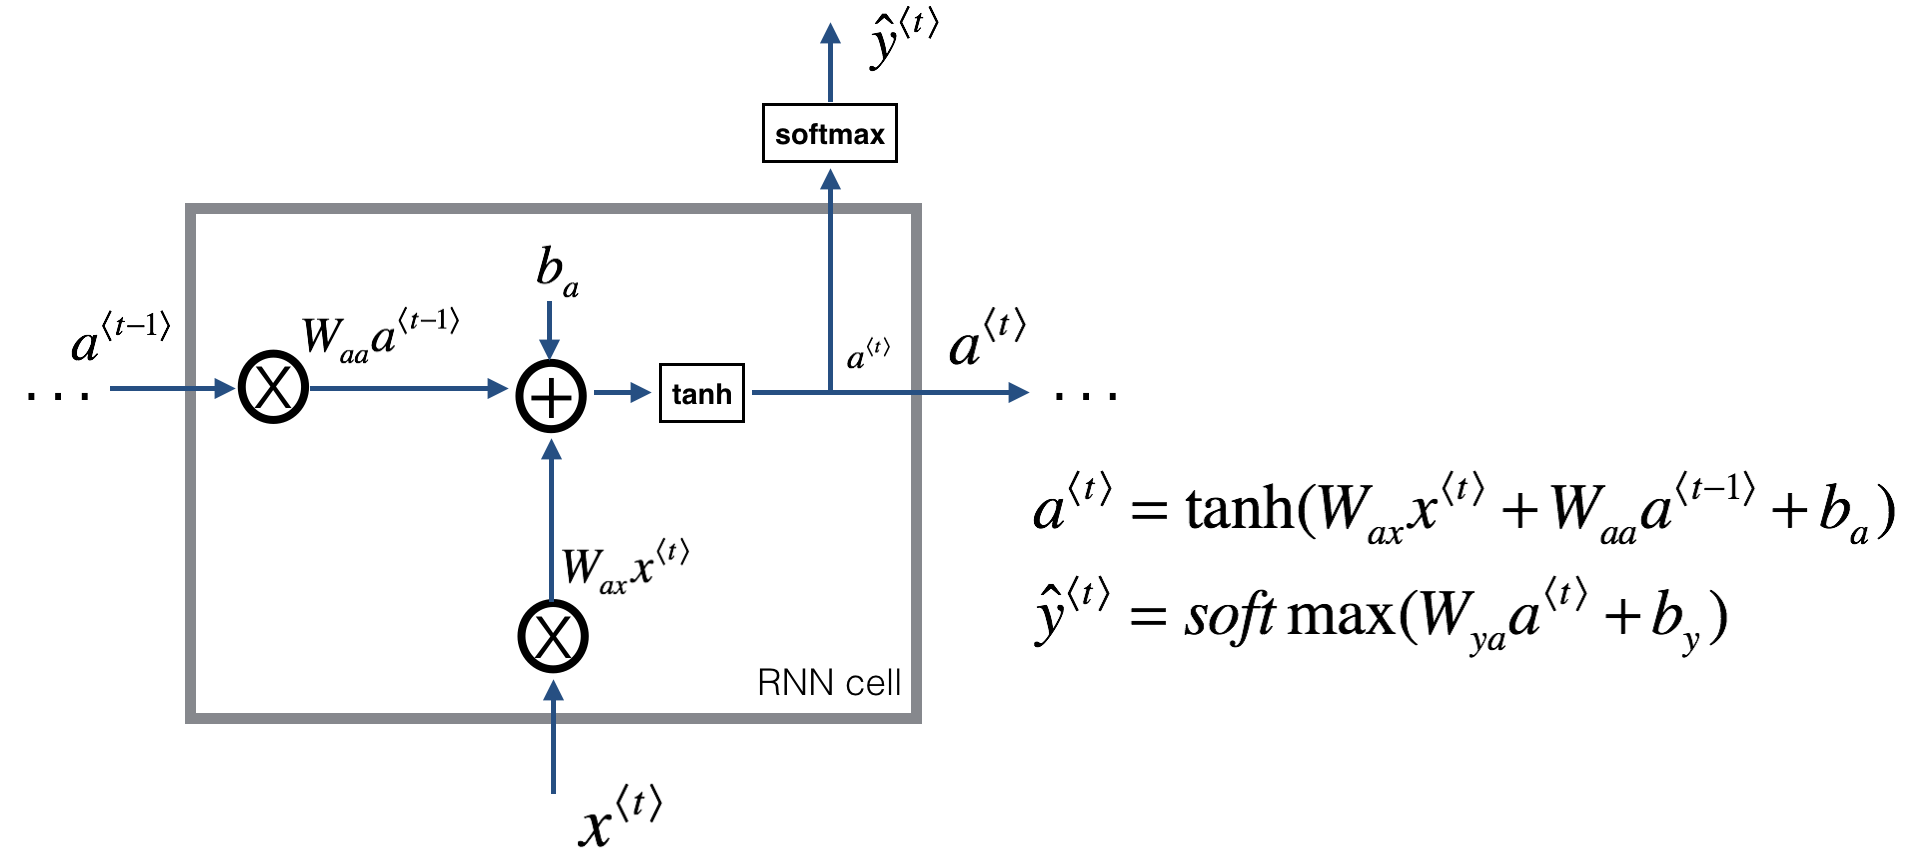

In [60]:
Image("images/rnn_vanilla.png")

## SPECIFY MODEL ARCHITECTURE

In [46]:
model = Sequential()
model.add(SimpleRNN(RNN_CELL_SIZE, activation='relu', return_sequences=True, input_shape=(None, MAX_PIANO_FREQ), stateful=True,
                   batch_input_shape=(BATCH_SIZE, None, MAX_PIANO_FREQ)))
# model.add(Dropout(DROPOUT_RATE))
model.add(Dense(NUM_UNIQUE_NOTES, activation='softmax'))
model.build()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (1, None, 128)            1065088   
                                                                 
 dense_2 (Dense)             (1, None, 1872)           241488    
                                                                 
Total params: 1,306,576
Trainable params: 1,306,576
Non-trainable params: 0
_________________________________________________________________


## CHOOSE OPTIMIZER AND COMPILE MODEL

In [47]:
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE, decay=DECAY_RATE)
model.compile(loss=LOSS_FN, optimizer=optimizer, metrics=METRICS)

## TRAIN MODEL

In [52]:
model.fit(X_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)

## EVALUATE MODEL AND MAKE PREDICTION

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy on test data: %.2f%%" % (scores[1]*100))

In [ ]:
y_predict = model.predict(X_test)

## CONVERT PREDICTION TO MIDI